# Import modules

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random

# Set Hyperparameter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(777)
if device == "cuda":
    torch.cuda.manual_seed_all(777)
print(f"using {device}")

batch_size = 100
learning_rate = 1e-3
num_epoch = 2000

using cuda


# Load Data

In [3]:
def get_alphabet(root: str, batch_size: int):
    
    train_path = os.path.join(root, 'train')
    test_path = os.path.join(root, 'test')
    
    train1_rotation = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                      transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1),
                                     transforms.RandomRotation(5)
                                 ]),
                                 target_transform=None)
    
    train2_default = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1)
                                     #, transforms.CenterCrop(26), transfroms.Resize(28)
                                 ]),
                                 target_transform=None)
    
    train3_crop = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1),
                                     transforms.CenterCrop(26),
                                     transforms.Resize(28)
                                 ]),
                                 target_transform=None)
    
    train4_inv = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1),
                                     transforms.RandomInvert()
                                 ]),
                                 target_transform=None)
    
    
    alphabet_test = ImageFolder(root = test_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Grayscale(1)
                                 ]),
                                 target_transform=None)
    
    train_loader = DataLoader(train1_rotation,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last=True,
                              num_workers=8)

    test_loader = DataLoader(alphabet_test,
                             batch_size=batch_size,
                             shuffle=False,
                             drop_last=False,
                             num_workers=8) 
    
    return (train1_rotation, train_loader, test_loader)

In [4]:
data_path = '/home/r320ws/Desktop/wooseok/MNISTClassification/Dataset/processed_data/'
original_data, train_loader, test_loader = get_alphabet(data_path, batch_size)

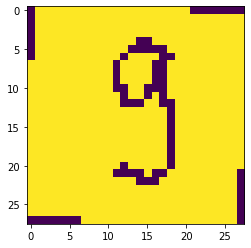

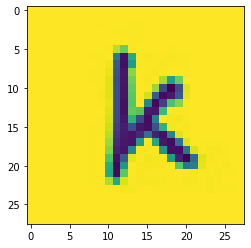

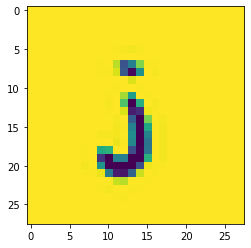

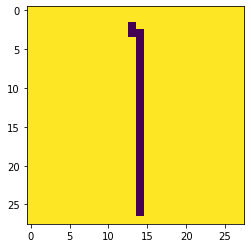

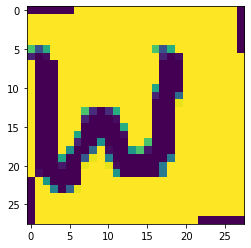

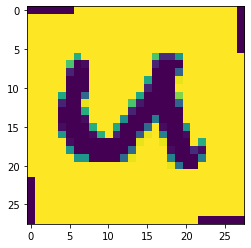

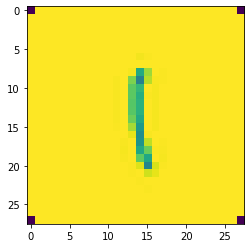

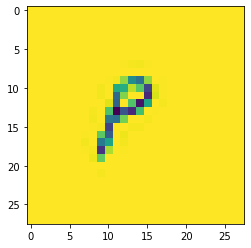

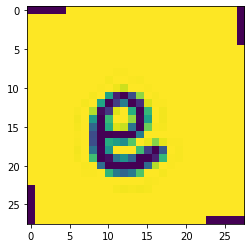

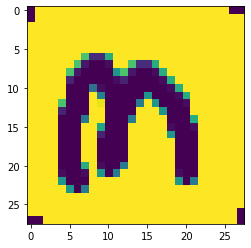

In [5]:
%matplotlib inline

def tensorToNumpy(tensor):
    c, w, h = tensor.shape
    
    img = np.zeros_like(tensor)
    img = img[0,:,:]
    img[:,:] = tensor[0,:,:]
    
    plt.figure()
    plt.imshow(img)

for i in random.choices(range(len(original_data)), k=10):
    image, target = original_data.__getitem__(i)
    tensorToNumpy(image)


# CNN Class

In [6]:
#### 
'''class CNN(nn.Module):  # train with rotated and adamw
    def __init__(self):
        a=32
        b=128
        c=512
        d=1024
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, a, 3, padding=1),
            nn.BatchNorm2d(a),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(          # 28x28      
            nn.Conv2d(a, b, 3, padding=1),
            nn.BatchNorm2d(b),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        self.layer3 = nn.Sequential(         #14x14
            nn.Conv2d(b, c, 3, padding=1),
            nn.BatchNorm2d(c),
            nn.ReLU(inplace=True),  
            nn.MaxPool2d(kernel_size=2, stride=2),
                         
            nn.Conv2d(c, d, 3, padding=1),
            nn.BatchNorm2d(d),
            nn.ReLU(inplace=True),  
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)            
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=d*4*4, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 26)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out'''

'''
## rotate, dropout04, optim_adam, kernel 5, out_feature = 512 ---> 99.56
## rotate, dropout04, optim_adam, kernel 3, out_feature = 512 ---> 99.48
class CNN(nn.Module):
    def __init__(self):
        a=32
        b=128
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(          # 28x28      

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer3 = nn.Sequential(         #14x14

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(c),
            nn.MaxPool2d(2, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=512*4*4, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 26)
        )
        
#         self.residual_layer = nn.Sequential(
#             nn.Conv2d(1, 128, 1)
#         )
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out'''
    
    
## rotate, dropout04, optim_adam, kernel all 5, out_feature = 512 ---> 99.56
## rotate, dropout04, optim_adam, kernel 3, out_feature = 512 ---> 99.48
class CNN(nn.Module):
    def __init__(self):
        a=32
        b=128
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(          # 28x28      

            nn.Conv2d(128, 256, 5, padding=2),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer3 = nn.Sequential(         #14x14

            nn.Conv2d(256, 512, 5, padding=2),
            nn.BatchNorm2d(c),
            nn.MaxPool2d(2, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(512, 26, kernel_size=5, padding=2),
            nn.BatchNorm2d(26),
            nn.AdaptiveAvgPool2d(1),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        

        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out

#         self.residual_layer = nn.Sequential(
#             nn.Conv2d(1, 128, 1)
#         )
        
#     def forward(self, x):
#         out = self.layer1(x) 
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc_layer(out)
#         return out

    
    
    
    
## 



'''class CNN(nn.Module):
    def __init__(self):
        a=32
        b=128
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(          # 28x28      

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer3 = nn.Sequential(         #14x14

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=512*4*4, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 26)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(512, 26, kernel_size=5, padding=2),
            nn.BatchNorm2d(26),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Dropout(0.4)
        )
        
        
#         self.residual_layer = nn.Sequential(
#             nn.Conv2d(1, 128, 1)
#         )
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out
'''
    
'''   0.991
class CNN(nn.Module):
    def __init__(self):
        a=32
        b=64
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, a, 3, padding=1),
            nn.BatchNorm2d(a),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(          # 28x28      
            nn.Conv2d(a, a, 3, padding=1),
            nn.BatchNorm2d(a),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        self.layer3 = nn.Sequential(         #14x14
            nn.Conv2d(a, b, 3, padding=1),
            nn.BatchNorm2d(b),
            nn.ReLU(inplace=True),  
            
            nn.Conv2d(b, b, kernel_size=3, padding=1),    #7x7
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=64*7*7, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 26)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out'''

'   0.991\nclass CNN(nn.Module):\n    def __init__(self):\n        a=32\n        b=64\n        c=512\n        \n        super(CNN, self).__init__()\n        self.layer1 = nn.Sequential(         # 28x28\n            nn.Conv2d(1, a, 3, padding=1),\n            nn.BatchNorm2d(a),\n            nn.ReLU(inplace=True),\n        )\n        self.layer2 = nn.Sequential(          # 28x28      \n            nn.Conv2d(a, a, 3, padding=1),\n            nn.BatchNorm2d(a),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(2,2)\n        )\n        self.layer3 = nn.Sequential(         #14x14\n            nn.Conv2d(a, b, 3, padding=1),\n            nn.BatchNorm2d(b),\n            nn.ReLU(inplace=True),  \n            \n            nn.Conv2d(b, b, kernel_size=3, padding=1),    #7x7\n            nn.BatchNorm2d(64),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2, stride=2)\n        )\n        self.fc_layer = nn.Sequential(\n            nn.Linear(in_features=64*7*7, o

# Define model

In [7]:
model = CNN().to(device)

# train1_2_ pretrained
# model = torch.load("./weights/rotate_drpout04_adamoptim_kernel5_126ep_acc99.5619888305664.pth").to(device)


loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-1)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)


# Training

In [8]:
def test_acc(model, test_loader=test_loader):
    correct = 0
    total = 0
    model = model.eval()
    with torch.no_grad():
        for image, label in test_loader:
            x = image.to(device)
            y = label.to(device)

            output = model.forward(x)
            _, output_index = torch.max(output, 1)

            total += label.size(0)
            correct += (output_index == y ).sum().float()

        return f"{100.0*correct/total}"

In [ ]:
max_accuracy =0.
from tqdm import tqdm

for i in range(1, num_epoch+1):
    model = model.train()
    for _, [image, label] in tqdm(enumerate(train_loader), total= len(train_loader)):
        x = image.to(device)
        y = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
    
    accuracy = float(test_acc(model))
    if (accuracy> max_accuracy and accuracy>99.5):
        max_accuracy = accuracy
        model_path = f"../weights/processed_Rotate_GAP_adam_reduceLR_all5kernel{i:03d}ep_acc{max_accuracy}.pth"
        torch.save(model, model_path)
    
    scheduler.step(accuracy)
    print(f"Epoch: {i}, Loss: {loss.item()},  \
          LR: {scheduler.optimizer.state_dict()['param_groups'][0]['lr']}, Acc: {accuracy}, \
          Best: {max_accuracy}")

100%|██████████| 221/221 [00:05<00:00, 41.11it/s]


Epoch: 1, Loss: 1.8361963033676147,            LR: 0.001, Acc: 68.30015563964844,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 42.06it/s]


Epoch: 2, Loss: 1.631909966468811,            LR: 0.001, Acc: 89.19273376464844,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 41.75it/s]


Epoch: 3, Loss: 1.3969725370407104,            LR: 0.001, Acc: 79.50120544433594,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 41.76it/s]


Epoch: 4, Loss: 1.436761736869812,            LR: 0.001, Acc: 92.32115173339844,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 41.37it/s]


Epoch: 5, Loss: 1.6288982629776,            LR: 0.001, Acc: 69.43775939941406,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 41.31it/s]


Epoch: 6, Loss: 1.3275028467178345,            LR: 0.001, Acc: 82.43273162841797,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 41.44it/s]


Epoch: 7, Loss: 1.4723248481750488,            LR: 0.001, Acc: 81.44825744628906,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.34it/s]


Epoch: 8, Loss: 1.4161685705184937,            LR: 0.001, Acc: 76.5696792602539,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.05it/s]


Epoch: 9, Loss: 1.3814175128936768,            LR: 0.001, Acc: 97.35287475585938,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.00it/s]


Epoch: 10, Loss: 1.3620193004608154,            LR: 0.001, Acc: 91.18354797363281,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.05it/s]


Epoch: 11, Loss: 1.6054415702819824,            LR: 0.001, Acc: 96.76219940185547,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 12, Loss: 1.277610421180725,            LR: 0.001, Acc: 98.79676055908203,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.89it/s]


Epoch: 13, Loss: 1.0457127094268799,            LR: 0.001, Acc: 94.61824798583984,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.06it/s]


Epoch: 14, Loss: 1.4414101839065552,            LR: 0.001, Acc: 99.27806091308594,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.38it/s]


Epoch: 15, Loss: 1.6102595329284668,            LR: 0.001, Acc: 98.94990539550781,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.82it/s]


Epoch: 16, Loss: 1.3646146059036255,            LR: 0.001, Acc: 89.12710571289062,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.97it/s]


Epoch: 17, Loss: 0.9582927823066711,            LR: 0.001, Acc: 93.9619369506836,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.99it/s]


Epoch: 18, Loss: 1.5879805088043213,            LR: 0.001, Acc: 99.36556243896484,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.14it/s]


Epoch: 19, Loss: 1.5236133337020874,            LR: 0.001, Acc: 98.9717788696289,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.83it/s]


Epoch: 20, Loss: 1.2595704793930054,            LR: 0.001, Acc: 98.77488708496094,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.40it/s]


Epoch: 21, Loss: 1.345032811164856,            LR: 0.001, Acc: 95.36206817626953,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 38.67it/s]


Epoch: 22, Loss: 1.4099618196487427,            LR: 0.001, Acc: 97.52789306640625,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.37it/s]


Epoch: 23, Loss: 1.3893558979034424,            LR: 0.001, Acc: 66.50623321533203,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.11it/s]


Epoch: 24, Loss: 1.6240997314453125,            LR: 0.001, Acc: 98.88426971435547,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.24it/s]


Epoch: 25, Loss: 1.4247772693634033,            LR: 0.001, Acc: 99.14679718017578,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.18it/s]


Epoch: 26, Loss: 1.505458116531372,            LR: 0.001, Acc: 99.2124252319336,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.81it/s]


Epoch: 27, Loss: 1.7789416313171387,            LR: 0.001, Acc: 99.38744354248047,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 38.45it/s]


Epoch: 28, Loss: 1.332167148590088,            LR: 0.001, Acc: 99.38744354248047,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.65it/s]


Epoch: 29, Loss: 1.5669946670532227,            LR: 0.001, Acc: 69.13148498535156,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.59it/s]


Epoch: 30, Loss: 1.3265079259872437,            LR: 0.001, Acc: 89.43338775634766,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.04it/s]


Epoch: 31, Loss: 1.2322088479995728,            LR: 0.001, Acc: 99.32181549072266,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 32, Loss: 1.3783049583435059,            LR: 0.001, Acc: 98.86239624023438,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.75it/s]


Epoch: 33, Loss: 1.4585332870483398,            LR: 0.001, Acc: 99.25617980957031,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.76it/s]


Epoch: 34, Loss: 0.8943618535995483,            LR: 0.001, Acc: 95.49332427978516,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 38.99it/s]


Epoch: 35, Loss: 1.2318921089172363,            LR: 0.001, Acc: 97.9654312133789,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.25it/s]


Epoch: 36, Loss: 1.256536602973938,            LR: 0.001, Acc: 98.05294036865234,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.08it/s]


Epoch: 37, Loss: 1.248378872871399,            LR: 0.001, Acc: 97.19973754882812,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.16it/s]


Epoch: 38, Loss: 1.0912233591079712,            LR: 0.0005, Acc: 98.7092514038086,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.20it/s]


Epoch: 39, Loss: 1.3138258457183838,            LR: 0.0005, Acc: 99.73747253417969,           Best: 99.73747253417969


100%|██████████| 221/221 [00:05<00:00, 40.11it/s]


Epoch: 40, Loss: 1.4404798746109009,            LR: 0.0005, Acc: 99.34368896484375,           Best: 99.73747253417969


100%|██████████| 221/221 [00:05<00:00, 39.51it/s]


Epoch: 41, Loss: 1.2743388414382935,            LR: 0.0005, Acc: 99.73747253417969,           Best: 99.73747253417969


100%|██████████| 221/221 [00:05<00:00, 40.17it/s]


Epoch: 42, Loss: 1.3398021459579468,            LR: 0.0005, Acc: 99.01553344726562,           Best: 99.73747253417969


100%|██████████| 221/221 [00:05<00:00, 38.02it/s]


Epoch: 43, Loss: 1.4716721773147583,            LR: 0.0005, Acc: 99.82498168945312,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.58it/s]


Epoch: 44, Loss: 1.2831933498382568,            LR: 0.0005, Acc: 99.64997100830078,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.38it/s]


Epoch: 45, Loss: 1.1855213642120361,            LR: 0.0005, Acc: 99.82498168945312,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 38.60it/s]


Epoch: 46, Loss: 1.3753029108047485,            LR: 0.0005, Acc: 99.34368896484375,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.78it/s]


Epoch: 47, Loss: 1.3413914442062378,            LR: 0.0005, Acc: 99.7155990600586,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.55it/s]


Epoch: 48, Loss: 1.2722656726837158,            LR: 0.0005, Acc: 99.75935363769531,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.84it/s]


Epoch: 49, Loss: 1.2086386680603027,            LR: 0.0005, Acc: 99.73747253417969,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 39.02it/s]


Epoch: 50, Loss: 1.17558753490448,            LR: 0.0005, Acc: 99.38744354248047,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 39.98it/s]


Epoch: 51, Loss: 1.666445016860962,            LR: 0.0005, Acc: 99.54058074951172,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 39.67it/s]


Epoch: 52, Loss: 1.4427447319030762,            LR: 0.0005, Acc: 99.58433532714844,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 38.70it/s]


Epoch: 53, Loss: 1.3066437244415283,            LR: 0.0005, Acc: 99.69371795654297,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.35it/s]


Epoch: 54, Loss: 1.2757285833358765,            LR: 0.00025, Acc: 99.75935363769531,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 38.53it/s]


Epoch: 55, Loss: 1.6317459344863892,            LR: 0.00025, Acc: 99.73747253417969,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.80it/s]


Epoch: 56, Loss: 1.3080157041549683,            LR: 0.00025, Acc: 99.80310821533203,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.20it/s]


Epoch: 57, Loss: 1.3489882946014404,            LR: 0.00025, Acc: 99.75935363769531,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.20it/s]


Epoch: 58, Loss: 1.179916501045227,            LR: 0.00025, Acc: 99.82498168945312,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 39.48it/s]


Epoch: 59, Loss: 1.5349969863891602,            LR: 0.00025, Acc: 99.67184448242188,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.26it/s]


Epoch: 60, Loss: 1.4353888034820557,            LR: 0.00025, Acc: 99.7155990600586,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 39.65it/s]


Epoch: 61, Loss: 1.4044418334960938,            LR: 0.00025, Acc: 99.73747253417969,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 39.06it/s]


Epoch: 62, Loss: 1.2409517765045166,            LR: 0.00025, Acc: 99.73747253417969,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.92it/s]


Epoch: 63, Loss: 1.3059500455856323,            LR: 0.00025, Acc: 99.73747253417969,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.75it/s]


Epoch: 64, Loss: 0.9788358807563782,            LR: 0.00025, Acc: 99.64997100830078,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.10it/s]


Epoch: 65, Loss: 1.1098377704620361,            LR: 0.000125, Acc: 99.7812271118164,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 39.71it/s]


Epoch: 66, Loss: 0.916647732257843,            LR: 0.000125, Acc: 99.84686279296875,           Best: 99.84686279296875


100%|██████████| 221/221 [00:05<00:00, 39.62it/s]


Epoch: 67, Loss: 1.401816964149475,            LR: 0.000125, Acc: 99.7812271118164,           Best: 99.84686279296875


100%|██████████| 221/221 [00:05<00:00, 39.45it/s]


Epoch: 68, Loss: 1.4364513158798218,            LR: 0.000125, Acc: 99.7155990600586,           Best: 99.84686279296875


100%|██████████| 221/221 [00:05<00:00, 40.01it/s]


Epoch: 69, Loss: 1.500477910041809,            LR: 0.000125, Acc: 99.75935363769531,           Best: 99.84686279296875


100%|██████████| 221/221 [00:05<00:00, 40.21it/s]


Epoch: 70, Loss: 1.3711978197097778,            LR: 0.000125, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.85it/s]


Epoch: 71, Loss: 1.2403427362442017,            LR: 0.000125, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.68it/s]


Epoch: 72, Loss: 1.4698001146316528,            LR: 0.000125, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.77it/s]


Epoch: 73, Loss: 1.3378371000289917,            LR: 0.000125, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.10it/s]


Epoch: 74, Loss: 1.4031904935836792,            LR: 0.000125, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 41.30it/s]


Epoch: 75, Loss: 1.3690872192382812,            LR: 0.000125, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.88it/s]


Epoch: 76, Loss: 1.2065446376800537,            LR: 0.000125, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.53it/s]


Epoch: 77, Loss: 0.9794563055038452,            LR: 0.000125, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.73it/s]


Epoch: 78, Loss: 1.1453427076339722,            LR: 0.000125, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.06it/s]


Epoch: 79, Loss: 1.3383363485336304,            LR: 0.000125, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 80, Loss: 1.0106043815612793,            LR: 0.000125, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.11it/s]


Epoch: 81, Loss: 1.3045498132705688,            LR: 6.25e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.74it/s]


Epoch: 82, Loss: 1.2071900367736816,            LR: 6.25e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.75it/s]


Epoch: 83, Loss: 1.4361441135406494,            LR: 6.25e-05, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.39it/s]


Epoch: 84, Loss: 1.1411715745925903,            LR: 6.25e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.26it/s]


Epoch: 85, Loss: 1.2716368436813354,            LR: 6.25e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.86it/s]


Epoch: 86, Loss: 1.3053655624389648,            LR: 6.25e-05, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.74it/s]


Epoch: 87, Loss: 1.2082467079162598,            LR: 6.25e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.65it/s]


Epoch: 88, Loss: 1.3394335508346558,            LR: 6.25e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.90it/s]


Epoch: 89, Loss: 1.304989218711853,            LR: 6.25e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.54it/s]


Epoch: 90, Loss: 1.2393909692764282,            LR: 6.25e-05, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.78it/s]


Epoch: 91, Loss: 1.043683648109436,            LR: 6.25e-05, Acc: 99.73747253417969,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.24it/s]


Epoch: 92, Loss: 1.403069019317627,            LR: 3.125e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.45it/s]


Epoch: 93, Loss: 1.4995815753936768,            LR: 3.125e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.70it/s]


Epoch: 94, Loss: 1.0774600505828857,            LR: 3.125e-05, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.39it/s]


Epoch: 95, Loss: 1.4018776416778564,            LR: 3.125e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.82it/s]


Epoch: 96, Loss: 1.6643245220184326,            LR: 3.125e-05, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.46it/s]


Epoch: 97, Loss: 1.0759962797164917,            LR: 3.125e-05, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.77it/s]


Epoch: 98, Loss: 1.273288607597351,            LR: 3.125e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.82it/s]


Epoch: 99, Loss: 1.6632059812545776,            LR: 3.125e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.98it/s]


Epoch: 100, Loss: 1.4343171119689941,            LR: 3.125e-05, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.36it/s]


Epoch: 101, Loss: 1.4371862411499023,            LR: 3.125e-05, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.93it/s]


Epoch: 102, Loss: 1.3059576749801636,            LR: 3.125e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.38it/s]


Epoch: 103, Loss: 1.3690906763076782,            LR: 1.5625e-05, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 41.33it/s]


Epoch: 104, Loss: 1.2393406629562378,            LR: 1.5625e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.79it/s]


Epoch: 105, Loss: 1.3376792669296265,            LR: 1.5625e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.64it/s]


Epoch: 106, Loss: 1.0762205123901367,            LR: 1.5625e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.65it/s]


Epoch: 107, Loss: 1.533218502998352,            LR: 1.5625e-05, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.28it/s]


Epoch: 108, Loss: 1.3371024131774902,            LR: 1.5625e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.80it/s]


Epoch: 109, Loss: 1.3050776720046997,            LR: 1.5625e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.73it/s]


Epoch: 110, Loss: 1.0763808488845825,            LR: 1.5625e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.86it/s]


Epoch: 111, Loss: 1.5338490009307861,            LR: 1.5625e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.87it/s]


Epoch: 112, Loss: 1.2423371076583862,            LR: 1.5625e-05, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.79it/s]


Epoch: 113, Loss: 1.2443758249282837,            LR: 1.5625e-05, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.46it/s]


Epoch: 114, Loss: 1.1080999374389648,            LR: 7.8125e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.31it/s]


Epoch: 115, Loss: 1.5331419706344604,            LR: 7.8125e-06, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.20it/s]


Epoch: 116, Loss: 1.4075199365615845,            LR: 7.8125e-06, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.37it/s]


Epoch: 117, Loss: 1.435377836227417,            LR: 7.8125e-06, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.97it/s]


Epoch: 118, Loss: 1.3730772733688354,            LR: 7.8125e-06, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.03it/s]


Epoch: 119, Loss: 1.336844801902771,            LR: 7.8125e-06, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.57it/s]


Epoch: 120, Loss: 1.305680274963379,            LR: 7.8125e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.59it/s]


Epoch: 121, Loss: 1.1758729219436646,            LR: 7.8125e-06, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 37.97it/s]


Epoch: 122, Loss: 1.2407984733581543,            LR: 7.8125e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.21it/s]


Epoch: 123, Loss: 1.2394590377807617,            LR: 7.8125e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.66it/s]


Epoch: 124, Loss: 1.239230990409851,            LR: 7.8125e-06, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.80it/s]


Epoch: 125, Loss: 1.565779209136963,            LR: 3.90625e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.87it/s]


Epoch: 126, Loss: 1.2066259384155273,            LR: 3.90625e-06, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.14it/s]


Epoch: 127, Loss: 0.9465964436531067,            LR: 3.90625e-06, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.74it/s]


Epoch: 128, Loss: 1.1105057001113892,            LR: 3.90625e-06, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.78it/s]


Epoch: 129, Loss: 1.4672367572784424,            LR: 3.90625e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.31it/s]


Epoch: 130, Loss: 1.1743745803833008,            LR: 3.90625e-06, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.10it/s]


Epoch: 131, Loss: 1.4667853116989136,            LR: 3.90625e-06, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.24it/s]


Epoch: 132, Loss: 1.2718087434768677,            LR: 3.90625e-06, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.16it/s]


Epoch: 133, Loss: 1.6646888256072998,            LR: 3.90625e-06, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.58it/s]


Epoch: 134, Loss: 1.240411639213562,            LR: 3.90625e-06, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.77it/s]


Epoch: 135, Loss: 1.3362599611282349,            LR: 3.90625e-06, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.81it/s]


Epoch: 136, Loss: 1.7337861061096191,            LR: 1.953125e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.69it/s]


Epoch: 137, Loss: 1.2726056575775146,            LR: 1.953125e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


 90%|█████████ | 200/221 [00:04<00:00, 40.29it/s]

In [ ]:
print(test_acc(model))